In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

In [2]:
plt.style.use('seaborn')

In [3]:
pd.options.mode.chained_assignment = None

In [4]:
def compare_two_hist(dfs, column_name, labels, xlabel, ylabel, title, stat_labels):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    sns.histplot(data=dfs[0], 
                 x=column_name, 
                 ax=ax, 
                 alpha=0.5, 
                 color='red', 
                 label=labels[0])

    sns.histplot(data=dfs[1], 
                 x=column_name, 
                 ax=ax, 
                 color='#C7F2A4', 
                 label=labels[1])

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.vlines(dfs[0][column_name].mean(), ymin=0, ymax=600, color='#1C6758', label=stat_labels[0])
    ax.vlines(dfs[1][column_name].mean(), ymin=0, ymax=600, ls='--', color='#8B5DFF', label=stat_labels[1])
    ax.legend();plt.show()


    
    

In [5]:
def detect_outliers(df: pd.DataFrame, column_name: str, strategy: str):
    if strategy == 'triple_sigma':
        mean = df[column_name].mean()
        std = df[column_name].std()
        return df.query(f'~( @mean - 3 * @std < {column_name} < @mean + 3 * @std)')
    elif strategy == 'iqr':
        q25 = df[column_name].quantile(.25)
        q75 = df[column_name].quantile(.75)
        iqr = q75 - q25
        return df.query(f'~( @q25 - 1.5 * @iqr < {column_name} < @q75 + 1.5 * @iqr)')

In [6]:
def outliers_report(df: pd.DataFrame, column_names , strategy: str):
    report = []
    for cn in column_names:
        if strategy == 'triple_sigma':
            mean = df[cn].mean()
            std = df[cn].std()
            report.append({
            'column_name': cn,
            'left outliers count': df.query(f'@mean - 3 * @std > {cn}').shape[0],
            'left outliers %': df.query(f'@mean - 3 * @std > {cn}').shape[0] / df.shape[0] * 100,
            
            'right outliers count': df.query(f'@mean + 3 * @std < {cn}').shape[0],
            'right outliers %': df.query(f'@mean + 3 * @std < {cn}').shape[0] / df.shape[0] * 100   
        })
        elif strategy == 'iqr':
            q25 = df[cn].quantile(.25)
            q75 = df[cn].quantile(.75)
            iqr = q75 - q25
            report.append({
            'column_name': cn,
            'left outliers count': df.query(f'@q25 - 1.5 * @iqr > {cn}').shape[0],
            'left outliers %': df.query(f'@q25 - 1.5 * @iqr > {cn}').shape[0] / df.shape[0] * 100,
            
            'right outliers count': df.query(f'@q75 + 1.5 * @iqr < {cn}').shape[0],
            'right outliers %': df.query(f'@q75 + 1.5 * @iqr < {cn}').shape[0] / df.shape[0] * 100 
        })
    return pd.DataFrame(report)


In [7]:
def plot_graphics(df, column_name, bins=30, range_hist=None, hist_color='#519872', boxplot_color='#B9D2D2', col_alias='', xlabel='', ylabel=''):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax1 = sns.histplot(data=df, x=column_name, ax=ax[0], bins=bins, binrange=range_hist, color=hist_color)
    ax1.set_title(f'Гистограмма столбца {col_alias if len(col_alias) > 0 else column_name}')
    
    ax2 = sns.boxplot(data=df, x=column_name, ax=ax[1], color=boxplot_color)
    ax2.set_title(f'Коробчатая диаграмма столбца {col_alias if len(col_alias) > 0 else column_name}')

    
    ax1.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения')
    ax1.set_ylabel(ylabel if len(ylabel) > 0 else 'Количество')
    ax2.set_xlabel(xlabel if len(xlabel) > 0 else 'Значения') 

In [8]:
def process_outliers(df: pd.DataFrame, column_name: str, strategy: str, do: str):
    df = df.copy()
    if strategy == 'triple_sigma':
        mean = df[column_name].mean()
        std = df[column_name].std()
        if do == 'delete':
            return df.query(f'(@mean - 3 * @std < {column_name} < @mean + 3 * @std)')
        elif do == 'fill_na':
            df.loc[~(mean - 3 * std < df[f'{column_name}']) | ~(df[f'{column_name}'] < mean + 3 * std), f'{column_name}'] = np.nan
            return df
    elif strategy == 'iqr':
        q25 = df[column_name].quantile(.25)
        q75 = df[column_name].quantile(.75)
        iqr = q75 - q25
        if do == 'delete':
            return df.query(f'( @q25 - 1.5 * @iqr < {column_name} < @q75 + 1.5 * @iqr)')
        elif do == 'fill_na':
            df.loc[~(q25 - 1.5 * iqr < df[f'{column_name}']) | ~(df[f'{column_name}'] < q75 + 1.5 * iqr), f'{column_name}'] = np.nan
            return df

In [9]:
def add_bar_labels(ax):
    if hasattr(ax, 'bar_label'):
        ax.bar_label(ax.containers[0])  
    else:
        for bar in ax.patches:
            ax.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height() / 2, f'{int(bar.get_width())}', va='center')

    plt.tight_layout()

## Загрузка данных

### Датасет `users_go`

In [10]:
try:
    users = pd.read_csv(filepath_or_buffer='datasets/users_go.csv')
except:
    users = pd.read_csv(filepath_or_buffer='https://code.s3.yandex.net/datasets/users_go.csv')

In [11]:
users.sample(10)

,user_id,name,age,city,subscription_type
148,149,Лиана,18,Екатеринбург,ultra
1025,1026,Савелий,26,Тюмень,free
1165,1166,Максим,26,Сочи,free
955,956,Денис,27,Омск,free
45,46,Александр,29,Пятигорск,ultra
1464,1465,Екатерина,30,Краснодар,free
502,503,Рамиль,27,Омск,ultra
430,431,Арина,18,Омск,ultra
281,282,Захар,33,Краснодар,ultra
1111,1112,Злата,16,Екатеринбург,free


In [12]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [13]:
print(f"Количество явных дубликатов: {users.duplicated().sum()}")

Количество явных дубликатов: 31


### Датасет `rides_go`

In [14]:
try:
    rides = pd.read_csv(filepath_or_buffer='datasets/rides_go.csv')
except:
    rides = pd.read_csv(filepath_or_buffer='https://code.s3.yandex.net/datasets/rides_go.csv')

In [15]:
rides.sample(10)

,user_id,distance,duration,date
8440,844,5359.413362,13.718827,2021-04-07
15515,1356,4351.152381,29.316821,2021-06-11
8753,869,2523.107910,14.055459,2021-02-24
16336,1412,4247.502137,0.500000,2021-11-28
12075,1107,5560.078187,20.680235,2021-09-03
14995,1316,5036.303340,32.584157,2021-02-15
2256,241,5123.119450,29.956226,2021-08-20
5240,563,2879.593738,25.341116,2021-05-24
13024,1177,730.557588,5.753338,2021-07-11
1283,140,2643.625638,19.861754,2021-02-10


In [16]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [17]:
print(f"Количество явных дубликатов: {rides.duplicated().sum()}")

Количество явных дубликатов: 0


### Датасет `subscriptions_go`

In [18]:
try:
    subs = pd.read_csv(filepath_or_buffer='datasets/subscriptions_go.csv')
except:
    subs = pd.read_csv(filepath_or_buffer='https://code.s3.yandex.net/datasets/subscriptions_go.csv')

In [19]:
subs

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


##  Предобработка данных

### Приведение столбца `date` к типу даты

Приведем столбец `date` к типу даты pandas в датасете `rides_go`

In [20]:
rides['date'] = pd.to_datetime(rides['date'])

In [21]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


### Выделение месяца из даты

In [22]:
rides['month'] = rides.date.dt.month

### Проверка наличия пропущенных данных и дубликатов

In [23]:
users.drop_duplicates(inplace=True)

In [24]:
rides['distance'] = rides['distance'].round(2)

Посмотрим на аномалии в столбцах ['distance', 'duration']

In [25]:
outliers_report(rides, ['distance', 'duration'], 'iqr')

,column_name,left outliers count,left outliers %,right outliers count,right outliers %
0,distance,910,5.036529,126,0.697366
1,duration,95,0.525791,82,0.453841


Видим, что достаточно много коротких дистанций - около 5%. В исследовательском анализе следует обратить на это внимание. В данном случае 'короткими' аномалиями считаются значения $x < q_{25} - 1.5\cdot IQR $

<div style="color:#343434 ;background-color:#F4EEEE" class="alert alert-block alert-info"> 
    
1. Создали новый столбец с месяцем в датасете `rides_go`
    
2. Привели столбец date в `rides_go` к типу даты в pandas
    
3. Удалили строки-дубликаты в `users_go`

4. Оценили процент аномалий в датасете `rides_go` в столбцах с длительностью и дистанцией поездок
    
</div>

## Исследовательский анализ данных

### Частота встречаемости городов

In [27]:
piv = (users
 .pivot_table(index='city', values='age', aggfunc='count')
 .reset_index()
 .set_axis(['Название города', 'Количество клиентов'], axis=1)
 .sort_values('Количество клиентов', ascending=False))
piv

,Название города,Количество клиентов
4,Пятигорск,219
0,Екатеринбург,204
5,Ростов-на-Дону,198
1,Краснодар,193
6,Сочи,189
3,Омск,183
7,Тюмень,180
2,Москва,168


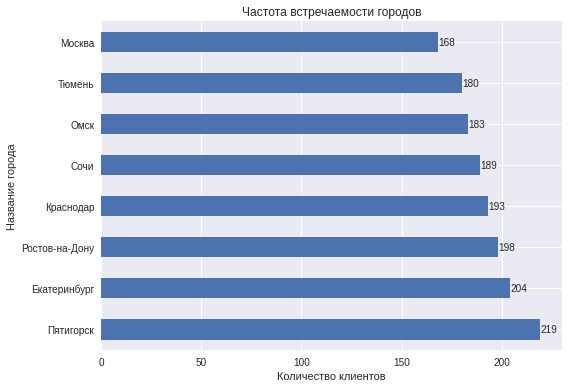

In [28]:
ax = piv.plot(kind='barh', title='Частота встречаемости городов', x='Название города', legend=False)
ax.set_xlabel('Количество клиентов')
add_bar_labels(ax)

<div style="color:#343434 ;background-color:#F4EEEE" class="alert alert-block alert-info"> 

1. Чаще всего встречается город Пятигорск

2. Реже всего - Москва
</div>

### Соотношение пользователей с подпиской и без подписки

In [29]:
(users
 .pivot_table(index=['subscription_type', 'city'], values=['age'], aggfunc=['count', 'mean'])
 .set_axis(['count', 'mean_age'], axis=1)
)

count   mean_age
subscription_type city                            
free              Екатеринбург      112  25.080357
                  Краснодар         112  24.598214
                  Москва             84  25.547619
                  Омск               92  25.119565
                  Пятигорск         125  25.024000
                  Ростов-на-Дону    109  24.394495
                  Сочи              103  24.679612
                  Тюмень             98  24.693878
ultra             Екатеринбург       92  24.804348
                  Краснодар          81  26.246914
                  Москва             84  24.988095
                  Омск               91  25.648352
                  Пятигорск          94  24.308511
                  Ростов-на-Дону     89  24.730337
                  Сочи               86  24.302326
                  Тюмень             82  24.573171

In [30]:
(users.pivot_table(index='subscription_type', values='age', aggfunc='count')
      .reset_index()
      .set_axis(['Тип подписки', 'Количество пользователей'], axis=1))

,Тип подписки,Количество пользователей
0,free,835
1,ultra,699


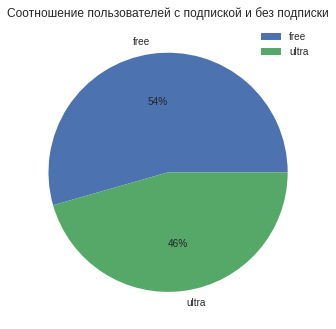

In [31]:
ax = (users.pivot_table(index='subscription_type', values='age', aggfunc='count')
      .replace({'ultra': 'с подпиской', 'free': 'без подписки'})
      .set_axis(['Количество пользователей'], axis=1)
      .plot(kind='pie', 
            title='Соотношение пользователей с подпиской и без подписки', 
            y='Количество пользователей',
            x='Тип подписки',
            ylabel='',
            legend=True, 
            autopct='%1.0f%%'))

<div style="color:#343434 ;background-color:#F4EEEE" class="alert alert-block alert-info"> 

1. Преобладает тип подписки <code>free</code> (835 без подписки против 699 с ultra)

2. Наибольшее количество пользователей (в обеих категориях подписки) в Пятигорске

3. В Краснодаре пользователи постарше (средний возраст около 26 лет) предпочитают тип подписки <code>ultra</code>
</div>

### Возраст пользователей

In [33]:
users.age.describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

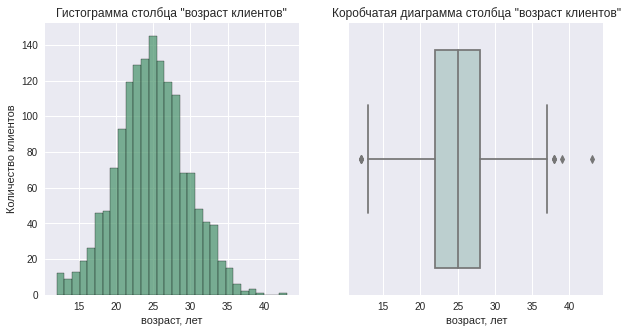

In [34]:
plot_graphics(users,
              column_name='age',
              col_alias='"возраст клиентов"',
              xlabel='возраст, лет',
              ylabel='Количество клиентов')

<div style="color:#343434 ;background-color:#F4EEEE" class="alert alert-block alert-info"> 
    
1. Распределение возраста пользователей похоже на нормальное со средним значением приблизительно равным 25 лет. 

2. Минимальный возраст пользователей - 12 лет, что является нарушением возрастных ограничений по прокату самокатов (минимальный возраст - 14 лет с письменным согласием законных представителей), в общем случае прокат разрешается с 18 лет. 
</div>



В данных представлена информации об определенных пользователях. Найдем их количество

In [35]:
rides.user_id.nunique()

1534

### Расстояние, которое пользователь преодолел за одну поездку

In [36]:
rides[['distance']].describe()

,distance
count,18068.000000
mean,3070.659992
std,1116.831222
min,0.860000
25%,2543.227500
50%,3133.610000
75%,3776.220000
max,7211.010000


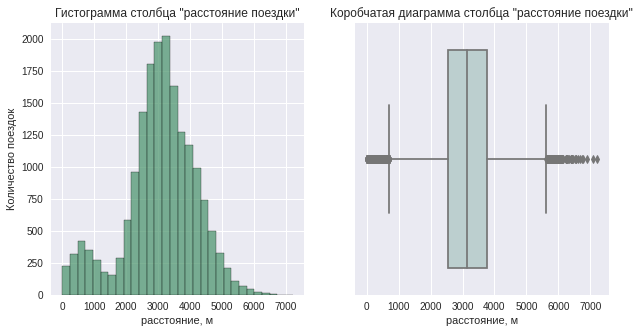

In [37]:
plot_graphics(rides,
              column_name='distance',
              col_alias='"расстояние поездки"',
              xlabel='расстояние, м',
              ylabel='Количество поездок')

Столбец distance имеет второй пик в малых дистанциях, похоже на бимодальное распределение

In [38]:
disctance_outliers = detect_outliers(rides, 'distance', 'iqr')
disctance_outliers.user_id.nunique()

661

Оказывается, что для практически половины пользователей существуют аномальные значения в столбце distance, отобранные по стратегии IQR

In [39]:
def categorize_distance(dist):
    if dist < 1500:
        return 'dist < 1500'
    else:
        return 'dist >= 1500'
    

In [40]:
rides['dist_type'] = rides['distance'].apply(categorize_distance)

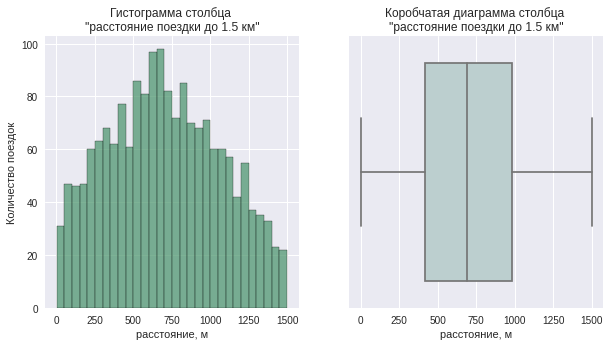

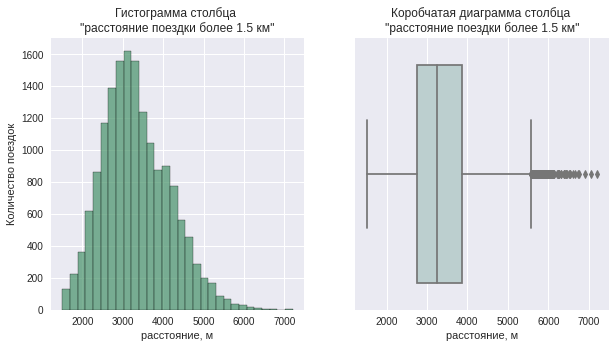

In [41]:
plot_graphics(rides.query('dist_type == "dist < 1500"'),
              column_name='distance',
              col_alias='\n"расстояние поездки до 1.5 км"',
              xlabel='расстояние, м',
              ylabel='Количество поездок'),
plot_graphics(rides.query('dist_type == "dist >= 1500"'),
              column_name='distance',
              col_alias='\n"расстояние поездки более 1.5 км"',
              xlabel='расстояние, м',
              ylabel='Количество поездок')

Посмотрим также распределение длительности поездок, дистанция которых менее 1.5 км

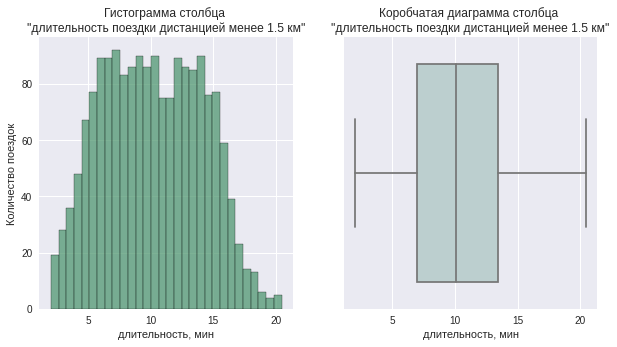

In [42]:
plot_graphics(rides.query('dist_type == "dist < 1500"'),
              column_name='duration',
              col_alias='\n"длительность поездки дистанцией менее 1.5 км"',
              xlabel='длительность, мин',
              ylabel='Количество поездок')

Видно, что той части поездок, дистанция которых не превышает 1.5 км соответствует распределение столбца duration, укладывающееся во временной отрезок от 0 до 20 минут. Фактически, этот пик на гистограмме фиксирует короткие по времени и по дистанции поездки. Возможно, эти поездки происходили в зоне с принудительно пониженной скоростью. Есть оочень маленькие по дистанции поездки, которые могли быть либо следствием системного сбоя, либо, например, человек увидел, что осталось мало заряда, доехал до ближайшей парковки самокатов и взял в прокат другой.

In [43]:
def categorize_duration(dur):
    if dur < 11:
        return 'dur < 11'
    else:
        return 'dur >= 11'

In [44]:
short_distance = rides.loc[rides.dist_type == "dist < 1500", :].copy()
short_distance['dur_type'] = short_distance['duration'].apply(categorize_duration)

Расчитаем среднюю скорость поездки

In [45]:
short_distance['mean_speed'] = (short_distance['distance']/1000) / (short_distance['duration']/60)

In [46]:
short_distance.pivot_table(index='dur_type', values=['mean_speed', 'distance'], aggfunc=['count', 'mean'])

count                   mean           
          distance mean_speed    distance mean_speed
dur_type                                            
dur < 11      1027       1027  633.726650   5.436258
dur >= 11      769        769  797.592549   3.412561

In [47]:
rides['mean_speed'] = (rides['distance']/1000) / (rides['duration']/60)

In [48]:
rides.pivot_table(index='dist_type', values=['mean_speed', 'distance', 'duration'], aggfunc=['count', 'mean'])

count                             mean                      
             distance duration mean_speed     distance   duration mean_speed
dist_type                                                                   
dist < 1500      1796     1796       1796   703.889722  10.170259   4.569764
dist >= 1500    16272    16272      16272  3331.889061  18.647687  14.802409

Действительно видно, что для столь малых по дистанции поездок скорость существенно ниже, чем средняя скорость всех поездок (3.4 или 5.44 против 13.8). Скорость указана в км/ч

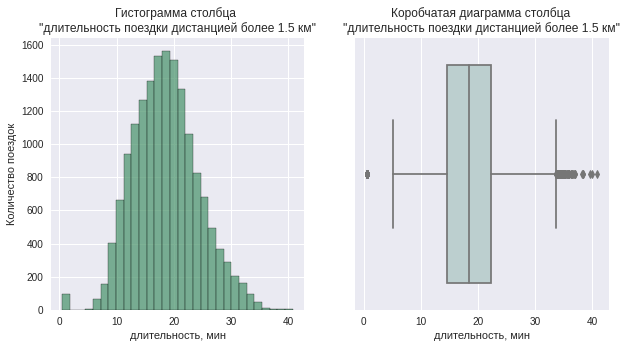

In [49]:
plot_graphics(rides.query('dist_type == "dist >= 1500"'),
              column_name='duration',
              col_alias='\n"длительность поездки дистанцией более 1.5 км"',
              xlabel='длительность, мин',
              ylabel='Количество поездок')

<div style="color:#343434 ;background-color:#F4EEEE" class="alert alert-block alert-info"> 

1. Распределение дистанции имеет бимодальный характер. 
2. Среднее значение дистанции поездки - 3070 м. Минимальное расстояние - менее метра, самое большое - 7211 метров
3. Больше всего дальних поездок (почти в 10 раз больше)
5. На гистограмме дистанции есть пик в области малых дистанций. Ему соответствует распределение длительности в диапазоне от 0 до 20 минут. То есть выделяется группа коротких поездок (со средним около 750 метров, их чуть меньше 10 процентов). Из анализа средней скорости можно заключить, что при дистанции меньше 1.5 км средняя скорость движения существенно ниже, чем средняя скорость среди всех поездок. Возможно, это зона с пониженной скоростью или прогулка на самокатах в парке.
</div>

### Продолжительность поездок

In [50]:
rides[['duration']].describe()

,duration
count,18068.000000
mean,17.805011
std,6.091051
min,0.500000
25%,13.597563
50%,17.678395
75%,21.724800
max,40.823963


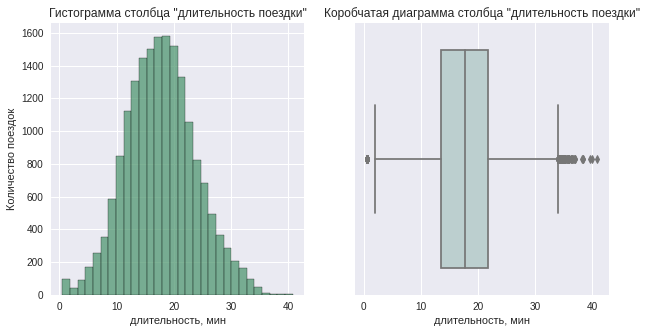

In [51]:
plot_graphics(rides,
              column_name='duration',
              col_alias='"длительность поездки"',
              xlabel='длительность, мин',
              ylabel='Количество поездок')

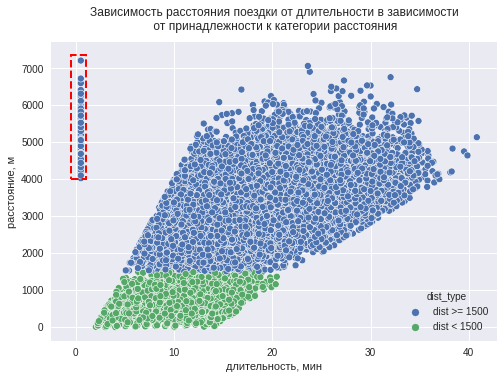

In [52]:
import matplotlib.patches as patches

g = sns.scatterplot(
    data=rides,
    x="duration",
    y="distance",
    hue="dist_type",
);

# g.fig.subplots_adjust(hspace=0.15)

g.axes.set_title('Зависимость расстояния поездки от длительности в зависимости\n от принадлежности к категории расстояния', y=1.02)

g.axes.set_xlabel('длительность, мин')
g.axes.set_ylabel('расстояние, м')
rect = patches.Rectangle((-0.5, 4000), 1.5, 3350, linewidth=2, edgecolor='r', facecolor='none', ls='--')
g.axes.add_patch(rect)
plt.show()

In [53]:
rides.query('duration < 1.5').describe()

,user_id,distance,duration,month,mean_speed
count,95.000000,95.000000,95.0,95.000000,95.000000
mean,1092.210526,5113.176737,0.5,6.484211,613.581208
std,244.028551,658.254223,0.0,3.709858,78.990507
min,701.000000,4030.310000,0.5,1.000000,483.637200
25%,901.000000,4611.510000,0.5,3.000000,553.381200
50%,1069.000000,5052.770000,0.5,6.000000,606.332400
75%,1310.500000,5488.460000,0.5,10.000000,658.615200
max,1524.000000,7211.010000,0.5,12.000000,865.321200


Заметим, что есть очень подозрительные данные в верхнем левом углу диаграммы рассеяния. Это дальние поездки с весьма малой длительностью. Вероятнее всего, это ошибка заполнения данных. Причем, она может крыться как в неправильном масштабе данных по времени (вместо минут часы, например), так и в масштабе данных по дистанции (см вместо метров). Таких данных не очень много (они выделены красным прямоугольником на диаграмме рассеяния).

In [54]:
(rides
 .pivot_table(index='dist_type', 
              values=['distance', 'duration'], 
              aggfunc=['count', 'median', 'mean'])
)

count             median                    mean           
             distance duration  distance   duration     distance   duration
dist_type                                                                  
dist < 1500      1796     1796   687.535  10.094883   703.889722  10.170259
dist >= 1500    16272    16272  3239.970  18.389323  3331.889061  18.647687

In [55]:
def month_season(mon):
    if mon in [12, 1, 2]:
        return 'зима'
    elif mon in [3, 4, 5]:
        return 'весна'
    elif mon in [6, 7, 8]:
        return 'лето'
    else:
        return 'осень'

In [56]:
rides['season'] = rides['month'].apply(month_season)

In [57]:
rides.pivot_table(index='season', values=['distance', 'duration'], aggfunc=['mean','count'])

mean               count         
           distance   duration distance duration
season                                          
весна   3068.506132  17.835427     4610     4610
зима    3085.406853  17.797718     4448     4448
лето    3074.295922  17.844228     4600     4600
осень   3054.245023  17.739665     4410     4410

В датасете представлены данные по всем временам года, причем практически в равных количествах. По сезонам данные сбалансированы

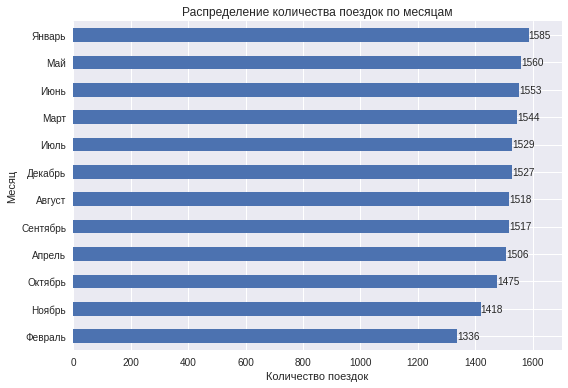

In [58]:
month_map = {
    1: 'Январь',
    2: 'Февраль',
    3: 'Март',
    4: 'Апрель',
    5: 'Май',
    6: 'Июнь',
    7: 'Июль',
    8: 'Август',
    9: 'Сентябрь',
    10: 'Октябрь',
    11: 'Ноябрь',
    12: 'Декабрь',
}

piv = (rides
      .pivot_table(index='month', values='distance', aggfunc='count')
      .reset_index())

piv['month'] = piv['month'].apply(lambda x: month_map[x])

ax = (piv
      .set_axis(['Месяц', 'Количество пользователей'], axis=1)
      .sort_values('Количество пользователей')
      .plot(kind='barh', 
            title='Распределение количества поездок по месяцам', 
            x='Месяц', 
            legend=False))

ax.set_xlabel('Количество поездок')
ax.set_xlim([0, 1700])
add_bar_labels(ax)

<div style="color:#343434 ;background-color:#F4EEEE" class="alert alert-block alert-info"> 
    
1. Распределение длительности похоже на нормальное, распределение дистанции имеет бимодальный характер. 

2. Больше всего дальних поездок (почти в 10 раз больше)

3. Есть область очень коротких поездок, имеющих в столбце дальности большие значения. Таких поездок всего 95

4. На гистограмме дистанции есть пик в области малых дистанций. Ему соответствует распределение длительности в диапазоне от 0 до 20 минут. То есть выделяется группа коротких поездок (со средним около 750 метров, их чуть меньше 10 процентов). Из анализа средней скорости можно заключить, что при дистанции меньше 1.5 км средняя скорость движения существенно ниже, чем средняя скорость среди всех поездок. Возможно, это зона с пониженной скоростью или прогулка на самокатах в парке.

5. Данные по поездкам сбалансированы по сезонам. Больше всего данных о поездках в Январе, меньше всего - в Феврале

6. Среднее значение длительности поездки около 18 минут, самая короткая поездка - 30 секунд, самая длительная - почти 41 минута

</div>

## Объединение данных

### Создание обогащенного датафрейма

In [59]:
rides_users = rides.merge(users, on='user_id', how='outer')
df = rides_users.merge(subs, on='subscription_type', how='outer')

In [60]:
df.sample(5)

,user_id,distance,duration,date,month,dist_type,mean_speed,season,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
7528,773,4560.22,23.047149,2021-08-13,8,dist >= 1500,11.871889,лето,Данил,29,Сочи,free,8,50,0
11775,1085,2918.62,23.919730,2021-09-19,9,dist >= 1500,7.321036,осень,Глеб,24,Пятигорск,free,8,50,0
5652,603,2392.15,12.520353,2021-01-03,1,dist >= 1500,11.463655,зима,Дарья,25,Пятигорск,ultra,6,0,199
7136,744,3532.93,14.152927,2021-04-10,4,dist >= 1500,14.977524,весна,Ксения,26,Екатеринбург,free,8,50,0
13195,1190,3654.28,21.966207,2021-02-26,2,dist >= 1500,9.981550,зима,Дарья,21,Пятигорск,free,8,50,0


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   dist_type          18068 non-null  object        
 6   mean_speed         18068 non-null  float64       
 7   season             18068 non-null  object        
 8   name               18068 non-null  object        
 9   age                18068 non-null  int64         
 10  city               18068 non-null  object        
 11  subscription_type  18068 non-null  object        
 12  minute_price       18068 non-null  int64         
 13  start_ride_price   18068 non-null  int64         
 14  subscr

### Разделение данных по типу подписки

In [62]:
df_ultra = df.loc[df.subscription_type == 'ultra']
df_free = df.loc[df.subscription_type == 'free']

In [63]:
df.pivot_table(index=['subscription_type', 'dist_type'], values=['distance', 'duration'], aggfunc='mean')

distance   duration
subscription_type dist_type                           
free              dist < 1500    615.268562   9.790207
                  dist >= 1500  3360.665312  18.376625
ultra             dist < 1500    955.361731  11.248698
                  dist >= 1500  3283.038132  19.107844

Отметим, что пользователи с подпиский совершают в среднем поездки на большие дистанции чем пользователи без подписки. Кроме того, средняя длительность поездки пользователей подписки выше чем у пользователей без подписки

In [64]:
df['age_group'] = df['age'].apply(lambda x: 'несовершеннолетние' if x < 18 else 'совершеннолетние')

In [65]:
df.pivot_table(index=['age_group', 'subscription_type'], values='mean_speed', aggfunc='count').set_axis(['count'], axis=1)

count
age_group          subscription_type       
несовершеннолетние free                 560
                   ultra                416
совершеннолетние   free               11008
                   ultra               6084

Заметим, что совершеннолетних все же значительно больше

Совершеннолетние пользователи совершают большинство поездок без подписки (разница весьма велика). Относительный разрыв в количестве пользователей с подпиской и без в группе несовершеннолетних не так велик. Во всех возрастных группах превалируют поездки без подписки

In [66]:
df.pivot_table(index=['age_group', 'city'], values=['duration'], aggfunc='count').set_axis(['count'], axis=1)

count
age_group          city                 
несовершеннолетние Екатеринбург      133
                   Краснодар         115
                   Москва             98
                   Омск               72
                   Пятигорск          63
                   Ростов-на-Дону    203
                   Сочи              169
                   Тюмень            123
совершеннолетние   Екатеринбург     2328
                   Краснодар        2186
                   Москва           1777
                   Омск             2005
                   Пятигорск        2461
                   Ростов-на-Дону   2247
                   Сочи             2090
                   Тюмень           1998

Больше всего несовершеннолетние совершали поездки в Ростове-на-Дону, а совершеннолетние - в Пятигорске

In [67]:
male_names = [
    'Станислав', 'Алексей', 'Константин', 'Игорь', 'Юрий', 'Ян', 'Валерий', 'Марк', 'Даниил', 
    'Святогор', 'Борис', 'Ростислав', 'Назар', 'Эдуард', 'Василий', 'Денис', 'Николай', 
    'Федор', 'Руслан', 'Иван', 'Ильдар', 'Данила', 'Дмитрий', 'Александр', 'Одиссей', 
    'Арсений', 'Максим', 'Павел', 'Рамиль', 'Родион', 'Тимур', 'Никита', 'Лев', 'Влад', 
    'Артур', 'Вячеслав', 'Владислав', 'Тамерлан', 'Вадим', 'Егор', 'Гордей', 'Святослав', 
    'Роберт', 'Амир', 'Богдан', 'Марат', 'Елисей', 'Макар', 'Глеб', 'Андрей', 'Марсель', 
    'Данил', 'Артемий', 'Альберт', 'Герман', 'Захар', 'Демид', 'Михаил', 'Степан', 'Тимофей', 
    'Даниэль', 'Рустам', 'Семен', 'Кирилл', 'Игнат', 'Виталий', 'Яромир', 'Евгений', 'Платон', 
    'Всеволод', 'Анатолий', 'Илья', 'Роман', 'Арсен', 'Айдар', 'Виктор', 'Мирон', 'Георгий', 
    'Петр', 'Олег', 'Дамир', 'Самир', 'Ярослав', 'Сергей', 'Эмиль', 'Радмир', 'Савелий', 
    'Антон', 'Мирослав', 'Тихон', 'Артём', 'Давид', 'Григорий', 'Леонид', 'Матвей'
]

In [68]:
df['gender'] = df['name'].apply(lambda x: 'male' if x in male_names else 'female')

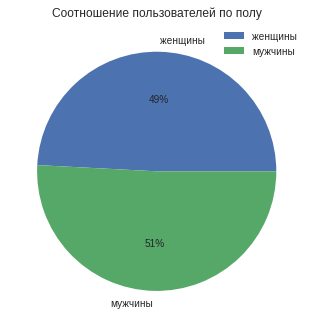

In [69]:
ax = (df.pivot_table(index='gender', values='age', aggfunc='count')
      .reset_index()
      .replace({'female': 'женщины', 'male': 'мужчины'})
      .set_axis(['Половая принадлежность', 'Количество пользователей'], axis=1)
      .set_index('Половая принадлежность')
      .plot(kind='pie', 
            title='Соотношение пользователей по полу', 
            y='Количество пользователей', 
            legend=True, 
            autopct = "%.0f%%",
            ylabel= ""))

In [70]:
df.pivot_table(index=['age_group', 'gender'], values=['mean_speed'], aggfunc='count').set_axis(['count'], axis=1)

count
age_group          gender       
несовершеннолетние female    441
                   male      535
совершеннолетние   female   8443
                   male     8649

По полу данные тоже практически сбалансированы (хотя в группе несовершеннолетних девушек на 21% поменьше)

In [71]:
df.pivot_table(index=['gender', 'subscription_type'], values=['mean_speed'], aggfunc='count').set_axis(['count'], axis=1)

count
gender subscription_type       
female free                5676
       ultra               3208
male   free                5892
       ultra               3292

В разрезе данных по полу можно заключить, что как женщины, так и мужчины больше всего совершают поездки без подписки (причем разница почти в 2 раза)

### Исследование данных по обеим категориям подписки

In [72]:
df_free[['duration', 'distance']].describe()

,duration,distance
count,11568.000000,11568.000000
mean,17.390909,3045.495284
std,6.326803,1246.173810
min,0.500000,0.860000
25%,12.958437,2366.560000
50%,17.326890,3114.650000
75%,21.594071,3905.695000
max,34.948498,7211.010000


In [73]:
df_ultra[['duration', 'distance']].describe()

,duration,distance
count,6500.000000,6500.000000
mean,18.541985,3115.445431
std,5.572048,836.895369
min,3.760353,244.210000
25%,14.524654,2785.447500
50%,18.178153,3148.640000
75%,21.884129,3560.577500
max,40.823963,5699.770000


Визуализируем данные о дистанции поездок и их длительности

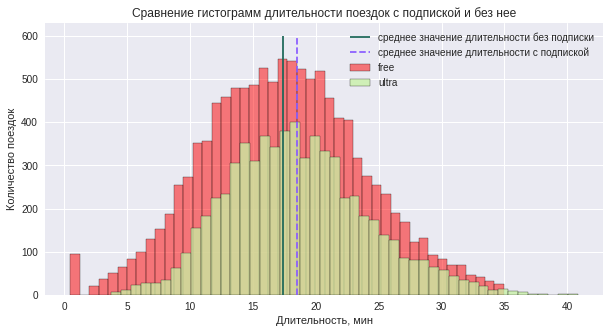

In [74]:
compare_two_hist(dfs=[df_free, df_ultra], 
                column_name='duration',
                xlabel='Длительность, мин',
                ylabel='Количество поездок',
                title='Сравнение гистограмм длительности поездок с подпиской и без нее',
                labels=['free', 'ultra'],
                stat_labels=['среднее значение длительности без подписки', 
                             'среднее значение длительности с подпиской'])


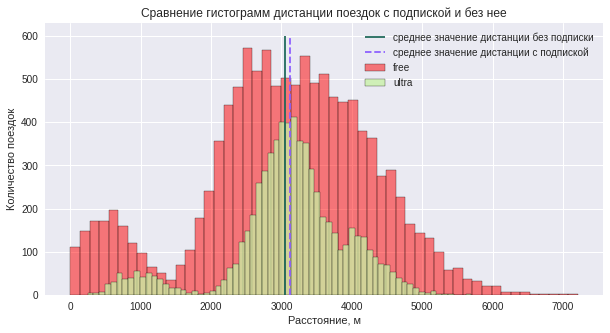

In [75]:
compare_two_hist(dfs=[df_free, df_ultra], 
                column_name='distance',
                xlabel='Расстояние, м',
                ylabel='Количество поездок',
                title='Сравнение гистограмм дистанции поездок с подпиской и без нее',
                labels=['free', 'ultra'],
                stat_labels=['среднее значение дистанции без подписки', 
                             'среднее значение дистанции с подпиской'])


In [77]:
df_ultra[['distance', 'duration']].describe().loc[['mean', '50%']]

,distance,duration
mean,3115.445431,18.541985
50%,3148.640000,18.178153


In [78]:
df_free[['distance', 'duration']].describe().loc[['mean', '50%']]

,distance,duration
mean,3045.495284,17.390909
50%,3114.650000,17.326890


<div style="color:#343434 ;background-color:#F4EEEE" class="alert alert-block alert-info"> 
    
1. Было произведено слияние датафреймов в один большой, содержащий данные о пользователях, поездках и деталей поездки (тарифов)

2. Пользователи с подпиский совершают в среднем поездки на большие дистанции чем пользователи без подписки

3. Средняя длительность поездки пользователей с подпиской больше чем у пользователей без подписки
    
4. Совершеннолетние пользователи совершают большинство поездок без подписки (разница весьма велика). Относительный разрыв в количестве пользователей с подпиской и без в группе несовершеннолетних не так велик. Во всех возрастных группах превалируют поездки без подписки

5. По полу данные практически сбалансированы (хотя в группе несовершеннолетних девушек на 21% поменьше)
    
6. У пользователей с подпиской средняя дистанция поездки равна 3115 м, а средняя длительность поездки составляет 18.54 мин. У пользователей без подписки средняя дистанция 3045.5 м, а средняя длительность составляет 17.4 мин.   
    
</div>

## Подсчёт выручки

In [79]:
df['duration'] = np.ceil(df['duration']).astype(int)

In [80]:
df.groupby('user_id')[['user_id', *list(subs.columns), 'age_group', 'season']].agg('first').reset_index(drop=True)

,user_id,subscription_type,minute_price,start_ride_price,subscription_fee,age_group,season
0,1,ultra,6,0,199,совершеннолетние,зима
1,2,ultra,6,0,199,совершеннолетние,весна
2,3,ultra,6,0,199,совершеннолетние,зима
3,4,ultra,6,0,199,совершеннолетние,зима
4,5,ultra,6,0,199,совершеннолетние,зима
...,...,...,...,...,...,...,...
1529,1530,free,8,50,0,совершеннолетние,зима
1530,1531,free,8,50,0,совершеннолетние,зима
1531,1532,free,8,50,0,совершеннолетние,зима
1532,1533,free,8,50,0,совершеннолетние,зима


### Агрегирование данных для каждого пользователя по месяцу

In [81]:
piv = (df
 .pivot_table(
     index=['user_id', 'month'], 
     values=['distance', 'duration'], 
     aggfunc={
        'distance': ['sum', 'count'],
        'duration': ['sum'],
})
 .reset_index()
 .set_axis(['user_id', 'month', 'count', 'dist_sum', 'dur_sum'], axis=1)
 .merge(df[['user_id', *list(subs.columns), 'age_group', 'season']].drop_duplicates(subset='user_id'), on='user_id')
 # .merge(df.groupby('user_id')[['user_id', *list(subs.columns), 'age_group', 'season']].agg('first').reset_index(drop=True), on='user_id')
)

piv

,user_id,month,count,dist_sum,dur_sum,subscription_type,minute_price,start_ride_price,subscription_fee,age_group,season
0,1,1,2,7027.51,42,ultra,6,0,199,совершеннолетние,зима
1,1,4,1,754.16,7,ultra,6,0,199,совершеннолетние,зима
2,1,8,2,6723.47,46,ultra,6,0,199,совершеннолетние,зима
3,1,10,2,5809.91,32,ultra,6,0,199,совершеннолетние,зима
4,1,11,3,7003.50,56,ultra,6,0,199,совершеннолетние,зима
...,...,...,...,...,...,...,...,...,...,...,...
11326,1534,6,2,3409.47,26,free,8,50,0,совершеннолетние,зима
11327,1534,8,2,7622.45,48,free,8,50,0,совершеннолетние,зима
11328,1534,9,1,4928.17,23,free,8,50,0,совершеннолетние,зима
11329,1534,11,4,13350.02,78,free,8,50,0,совершеннолетние,зима


Проверим на наличие пропусков после объединения

In [82]:
piv.isna().sum()

user_id              0
month                0
count                0
dist_sum             0
dur_sum              0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
age_group            0
season               0
dtype: int64

### Вычисление помесячной выручки

In [83]:
def calculate_proceeds(row):
    return row['count'] * row['start_ride_price'] + row['minute_price'] * row['dur_sum'] + row['subscription_fee']

piv['monthly_proceeds'] = piv.apply(calculate_proceeds, axis=1)

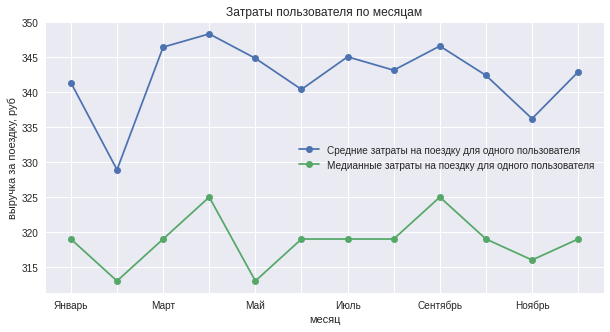

In [84]:
piv_for_graph = piv.pivot_table(index='month', values='monthly_proceeds', aggfunc=['mean', 'median']).reset_index()
piv_for_graph['month'] = piv_for_graph['month'].apply(lambda x: month_map[x])

ax = (piv_for_graph
 .set_index('month')
 .set_axis(['Средние затраты на поездку для одного пользователя', 'Медианные затраты на поездку для одного пользователя'], axis=1)
 .plot(marker='o', figsize=(10, 5), title='Затраты пользователя по месяцам', xlabel='месяц', ylabel='выручка за поездку, руб'))
plt.xticks(np.arange(len(list(piv_for_graph.index))))
plt.show()

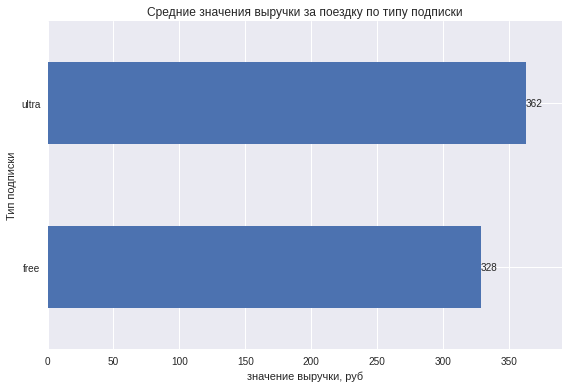

In [85]:
ax = (piv
      .pivot_table(index='subscription_type', values='monthly_proceeds', aggfunc='mean')
      .reset_index()
      .set_axis(['Тип подписки', 'Средние значения выручки за поездку по типу подписки'], axis=1)
      .plot(kind='barh', title='Средние значения выручки за поездку по типу подписки', x='Тип подписки', legend=False))

ax.set_xlabel('значение выручки, руб')
ax.set_xlim([0, 390])
add_bar_labels(ax)

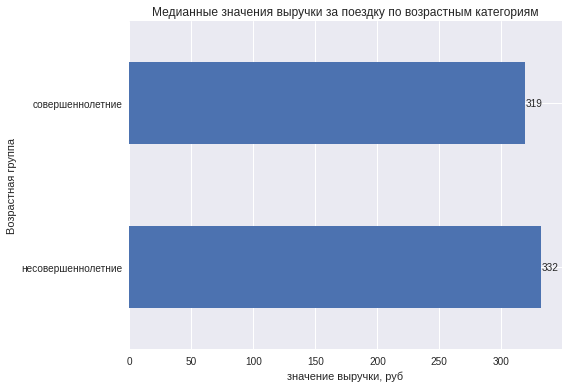

In [86]:
ax = (piv
      .pivot_table(index='age_group', values='monthly_proceeds', aggfunc='median')
      .reset_index()
      .set_axis(['Возрастная группа', 'Медианные значения выручки за поездку по возрастным категориям'], axis=1)
      .plot(kind='barh', title='Медианные значения выручки за поездку по возрастным категориям', x='Возрастная группа', legend=False))

ax.set_xlabel('значение выручки, руб')
add_bar_labels(ax)

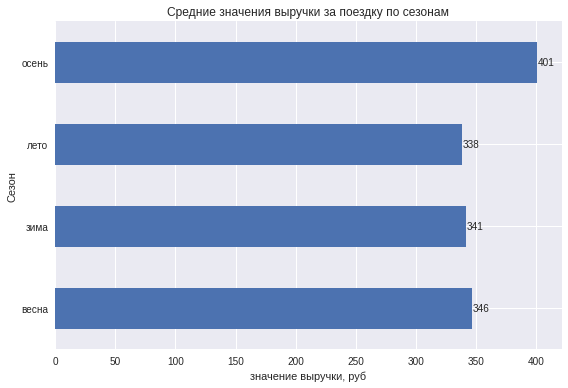

In [87]:
ax = (piv
      .pivot_table(index='season', values='monthly_proceeds', aggfunc='mean')
      .reset_index()
      .set_axis(['Сезон', 'Средние значения выручки за поездку по сезонам'], axis=1)
      .plot(kind='barh', title='Средние значения выручки за поездку по сезонам', x='Сезон', legend=False))

ax.set_xlabel('значение выручки, руб')
add_bar_labels(ax)

<div style="color:#343434 ;background-color:#F4EEEE" class="alert alert-block alert-info"> 
    
1. Наибольшая выручка была получена в апреле (348.3 руб. за поездку)

2. Средняя выручка от пользователей с подпиской больше чем от пользователей без подписки 

3. Средняя выручка от несовершеннолетних оказалась выше чем от взрослых людей
    
4. Максимальное значение средней выручки наблюдается в осенние месяцы    
</div>

## Проверка гипотез

### Гипотеза о равенстве средних значений длительности поездок

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.

<div style="color:#343434 ;background-color:#FFC95F" class="alert alert-block alert-info"> 
$H_0$: средняя длительность поездки клиентов с подпиской и без подписки равны

$H_1:$ средняя длительность поездки клиентов с подпиской больше чем средняя длительность поездки клиентов без подписки
    
Уровень значимости: $\alpha = 5\%$
    
</div>

In [88]:
alpha = .05

results = st.ttest_ind(
    df_ultra.duration,
    df_free.duration,
    alternative='greater'
)

print(f'Средняя длительность с подпиской: {df_ultra.duration.mean()}')
print(f'Средняя длительность без подписки: {df_free.duration.mean()}\n')


if results.pvalue < alpha:
    print(f'P-value = {results.pvalue}, alpha = {alpha}.\n\nH0 отвергается')
else:
    print(f'P-value = {results.pvalue}, alpha = {alpha}.\n\nНе отвергаем H0')
    

Средняя длительность с подпиской: 18.54198516280583
Средняя длительность без подписки: 17.39090929866399

P-value = 1.2804098316645618e-34, alpha = 0.05.

H0 отвергается


<div style="color:#1C315E ;background-color:#ABC270" class="alert alert-block alert-info"> 
<b>Вывод:</b> гипотеза о равенстве была отвергнута. Средние значения значимо различаются. 
    
Можно заключить, что средняя длительность поездки клиентов с подпиской больше чем средняя длительность поездки клиентов без подписки
</div>

### Гипотеза об оптимальном расстоянии одной поездки для клиентов с подпиской

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
<div style="color:#343434 ;background-color:#FFC95F" class="alert alert-block alert-info"> 
$H_0:$ среднее значение дистанции поездки клиентов с подпиской приблизительно равно 3130 метров

$H_1:$ среднее значение дистанции поездки клиентов с подпиской не превышает 3130 метров
    
Уровень значимости: $\alpha = 5\%$
    
</div>

In [89]:
df_ultra.distance.mean()

3115.445430769231

In [90]:
alpha = .05

results = st.ttest_1samp(
    df_ultra.distance,
    3130,
    alternative='less'
)

if results.pvalue < alpha:
    print(f'P-value = {results.pvalue}, alpha = {alpha}.\n\nH0 отвергается')
else:
    print(f'P-value = {results.pvalue}, alpha = {alpha}.\n\nНе отвергаем H0')
    

P-value = 0.0804637394157586, alpha = 0.05.

Не отвергаем H0


<div style="color:#1C315E ;background-color:#ABC270" class="alert alert-block alert-info"> 
<b>Вывод:</b> гипотеза о равенстве не была отвергнута. 
    
Можно заключить, что средняя дистанция поездки примерно равна 3130 метров, что соответствует рассчитанному оптимальному расстоянию с точки зрения износа самоката
</div>

### Гипотеза о помесячной выручке

Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?
<div style="color:#343434 ;background-color:#FFC95F" class="alert alert-block alert-info"> 
$H_0:$ помесячная выручка от людей с подпиской и от людей без подписки примерно равна

$H_1:$ помесячная выручка от людей с подпиской больше чем от людей без подписки
    
Уровень значимости: $\alpha = 5\%$
    
</div>

In [91]:
piv.pivot_table(index=['subscription_type','month'], values='monthly_proceeds', aggfunc=['mean', 'count'])

mean            count
                        monthly_proceeds monthly_proceeds
subscription_type month                                  
free              1           323.083333              600
                  2           313.527410              529
                  3           336.715827              556
                  4           335.620253              553
                  5           328.150087              573
                  6           326.220713              589
                  7           329.249110              562
                  8           331.178761              565
                  9           335.701906              577
                  10          330.469945              549
                  11          322.659459              555
                  12          330.600000              590
ultra             1           369.507692              390
                  2           351.898305              354
                  3           360.121212              396
                  4           367.160428              374
                  5           368.481481              405
                  6           361.391960              398
                  7           367.861538              390
                  8           360.765625              384
                  9           364.329577              355
                  10          360.032258              372
                  11          357.474576              354
                  12          363.011080              361

In [92]:
hyp_results = []
for m in piv.month.unique():
    
    item = {}
    
    results = st.ttest_ind(
    piv.loc[(piv.month == m) & (piv.subscription_type == 'ultra'), 'monthly_proceeds'],
    piv.loc[(piv.month == m) & (piv.subscription_type == 'free'), 'monthly_proceeds'],
    alternative='greater'
)
    item['month'] = month_map[m]
    item['with_ultra_monthly_proceeds'] = piv.loc[(piv.month == m) & (piv.subscription_type == "ultra"), "monthly_proceeds"].mean()
    item['free_monthly_proceeds'] = piv.loc[(piv.month == m) & (piv.subscription_type == "free"), "monthly_proceeds"].mean()
    item['p-value'] = results.pvalue.round(4)
        
    if results.pvalue < alpha:
        item['verdict'] = 'выручка от людей с подпиской больше в этот месяц'
    else:
        item['verdict'] = 'Не отвергаем H0'    
    
    hyp_results.append(item)
    
pd.DataFrame(hyp_results)

,month,with_ultra_monthly_proceeds,free_monthly_proceeds,p-value,verdict
0,Январь,369.507692,323.083333,0.0000,выручка от людей с подпиской больше в этот месяц
1,Апрель,367.160428,335.620253,0.0011,выручка от людей с подпиской больше в этот месяц
2,Август,360.765625,331.178761,0.0022,выручка от людей с подпиской больше в этот месяц
3,Октябрь,360.032258,330.469945,0.0019,выручка от людей с подпиской больше в этот месяц
4,Ноябрь,357.474576,322.659459,0.0002,выручка от людей с подпиской больше в этот месяц
5,Декабрь,363.011080,330.600000,0.0012,выручка от людей с подпиской больше в этот месяц
6,Март,360.121212,336.715827,0.0107,выручка от людей с подпиской больше в этот месяц
7,Июнь,361.391960,326.220713,0.0002,выручка от людей с подпиской больше в этот месяц
8,Июль,367.861538,329.249110,0.0001,выручка от людей с подпиской больше в этот месяц
9,Февраль,351.898305,313.527410,0.0001,выручка от людей с подпиской больше в этот месяц


In [93]:
results = st.ttest_ind(
    piv.loc[(piv.subscription_type == 'ultra'), 'monthly_proceeds'],
    piv.loc[(piv.subscription_type == 'free'), 'monthly_proceeds'],
    alternative='greater'
)

if results.pvalue < alpha:
    print(f'P-value = {results.pvalue}, alpha = {alpha}.\n\nH0 отвергается: средняя выручка от клиентов с подпиской больше')
else:
    print(f'P-value = {results.pvalue}, alpha = {alpha}.\n\nНе отвергаем H0')

P-value = 1.8850394384715216e-31, alpha = 0.05.

H0 отвергается: средняя выручка от клиентов с подпиской больше


<div style="color:#1C315E ;background-color:#ABC270" class="alert alert-block alert-info"> 
<b>Вывод:</b> гипотеза о равенстве средней выручки была отвергнута. Средние значения значимо различаются. 
    
Можно заключить, что средняя помесячная выручка от клиентов с подпиской больше чем от клиентов без подписки
</div>

### Задача по гипотезам

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?


Ответ: Необходим тест `scipy.stats.ttest_rel(before, after, alternative='greater')`. Так как мы проверяем зависимые выборки (до и после обновления). Гипотеза односторонняя, в качестве параметра alternative используем значение greater

<div style="color:#343434 ;background-color:#F4EEEE" class="alert alert-block alert-info"> 
    
1. Cредняя длительность поездки клиентов с подпиской больше чем средняя длительность поездки клиентов без подписки

2. <b>Cредняя дистанция поездки примерно равна 3130 метров</b>

3. Cредняя помесячная выручка от клиентов с подпиской больше чем от клиентов без подписки
</div>

##  Распределения

### Промокоды

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 
100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5%. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Будем итеративно подбирать число промокодов согласно условию: $$n = \text{argmin}\left({\left|\sum_{k=0}^{100} C_n^k\cdot p^k\cdot(1-p)^{n-k} - 0.05\right|}\right)$$

In [94]:
p = 0.1
prob = 1
n = 100

while abs(prob - .0009)  > .05:
    prob = st.binom.cdf(100, n, p)
    n += 1

print(f'Количество промокодов = {n}, P(меньше 100 продливших) = {prob}\n')

for i in range(n-2, n+3):
    prob = st.binom.cdf(100, i, p)
    print(f'Количество промокодов = {i}, |0.05 - P(меньше 100 продливших)| = {abs(.05 - prob)}')

Количество промокодов = 1172, P(меньше 100 продливших) = 0.0505235199072141

Количество промокодов = 1170, |0.05 - P(меньше 100 продливших)| = 0.0015149167374162165
Количество промокодов = 1171, |0.05 - P(меньше 100 продливших)| = 0.0005235199072140956
Количество промокодов = 1172, |0.05 - P(меньше 100 продливших)| = 0.00045204789796929323
Количество промокодов = 1173, |0.05 - P(меньше 100 продливших)| = 0.0014119629361277405
Количество промокодов = 1174, |0.05 - P(меньше 100 продливших)| = 0.00235640124534027


/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


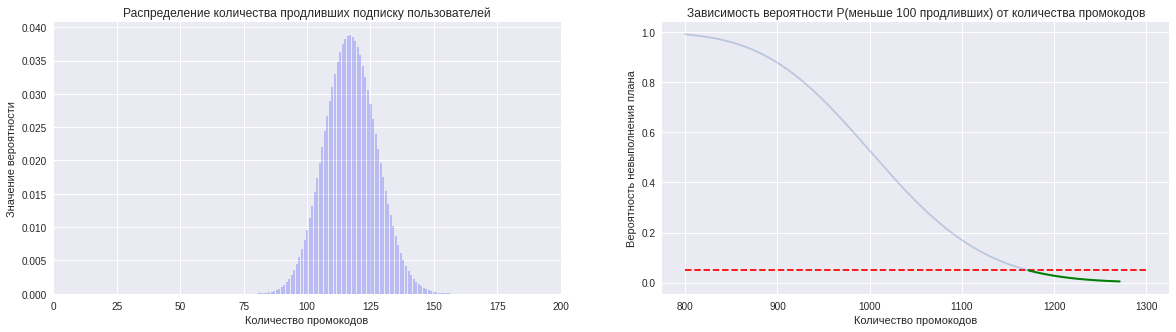

In [95]:
distr = []
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

for k in range(0, n + 1):
    current_value = st.binom.pmf(k, n, p)
    distr.append(current_value)
    
ax[0].bar(range(0, n + 1), distr, color='blue', alpha=0.2)
ax[0].set_xlim([0, 200])
ax[0].set_title('Распределение количества продливших подписку пользователей')
ax[0].set_xlabel('Количество промокодов')
ax[0].set_ylabel('Значение вероятности')


fail_values = []
for i in range(100, n + 100):
    fail_values.append(st.binom.cdf(100, i, p))
    
ax[1].plot(range(800, n + 100), fail_values[700:], alpha=0.3)
ax[1].hlines(y=.05, xmin=800, xmax=1300, color='red', ls='--')

ax[1].plot(range(n, n+100), fail_values[n-100:], color='green', linewidth=2)
ax[1].set_title('Зависимость вероятности P(меньше 100 продливших) от количества промокодов')
ax[1].set_xlabel('Количество промокодов')
ax[1].set_ylabel('Вероятность невыполнения плана')

plt.show()

<div style="color:#343434 ;background-color:#F4EEEE" class="alert alert-block alert-info"> 
   Чтобы снизить вероятность невыполнения плана до 5%, необходимо раздать 1172 промокода. Исследование было произведено с помощью моделирования ситуации биномиальным распределением, которое изображено выше слева
</div>

### Push-уведомления

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [96]:
p = .4
n = 1000000
interested_value = 399500

Проверим условие аппроксимации

In [97]:
if n * p - np.sqrt(n * p * (1 - p)) >= 0 and n * p + np.sqrt(n * p * (1 - p)) <= n:
    print('Удовлетворяет условию аппроксимации нормальным распределением')
else:
    print('НЕ удовлетворяет условию аппроксимации нормальным распределением')

Удовлетворяет условию аппроксимации нормальным распределением


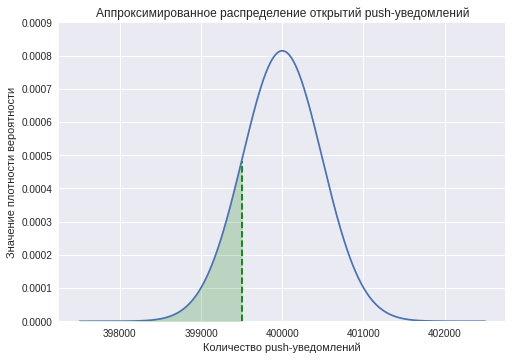

In [98]:
x = np.linspace(397500, 402500, 1000000)
distr = st.norm(n * p, np.sqrt(n * p * (1 - p)))

plt.plot(x, distr.pdf(x))

plt.title('Аппроксимированное распределение открытий push-уведомлений')
plt.ylim([0, 0.0009])

plt.vlines(x=interested_value, ymin=0, ymax=distr.pdf(interested_value), color='green', ls='--')

x_mask = x[x < interested_value]
plt.fill_between(x_mask, distr.pdf(x)[:x_mask.shape[0]], alpha=0.2, color='green')
plt.xlabel('Количество push-уведомлений')
plt.ylabel('Значение плотности вероятности')

plt.show()

In [99]:
print(f'P(уведомление откроют не более 399,5 тыс. пользователей) = {distr.cdf(399500)}')

P(уведомление откроют не более 399,5 тыс. пользователей) = 0.15371708296369768


<div style="color:#343434 ;background-color:#F4EEEE" class="alert alert-block alert-info"> 
   Если отдел планирует разослать 1000000 уведомлений, которые открывают около 40% получивших клиентов, то вероятность, что уведомления откроют не более 399.5 тыс. клиентов приблизительно равна 15% (0.15)
</div>

## Итоговый вывод

<div style="color:#343434 ;background-color:#F4EEEE" class="alert alert-block alert-info"> 
<b>ВЫВОД:</b> 
    
1. В датасете users_go были найдены явные дубликаты (удалены на шаге предобработке)
2. Преобладает тип подписки <code>free</code> (835 без подписки против 699 с ultra)
<hr>

3. Наибольшее количество пользователей - жители Пятигорска
4. В Краснодаре клиенты постарше (средний возраст около 26 лет) предпочитают тип подписки <code>ultra</code>
5. Большинство совершеннолетних пользователей совершают поездки без подписки (разница весьма велика). Относительный разрыв в количестве пользователей с подпиской и без в группе несовершеннолетних не так велик. Во всех возрастных группах превалируют поездки без подписки
6. По полу данные практически сбалансированы (в группе несовершеннолетних девушек на 21% поменьше)
<hr>

7. Больше всего дальних поездок (почти в 10 раз больше)
8. <b> Есть область очень коротких поездок, имеющих в столбце дальности большие значения. Вероятнее всего, это ошибка заполнения данных. Причем, она может крыться как в неправильном масштабе данных по времени (вместо минут часы, например), так и в масштабе данных по дистанции (см вместо метров) </b>
9. В распределении дистанции есть пик в области малых дистанций. Ему соответствует распределение длительности в диапазоне от 0 до 20 минут. То есть выделяется группа коротких поездок (со средним около 750 метров, их чуть меньше 10 процентов). Из анализа средней скорости можно заключить, что при дистанции меньше 1.5 км средняя скорость движения существенно ниже, чем средняя скорость среди всех поездок. Возможно, это зона с пониженной скоростью или прогулка на самокатах в парке.
10. Выяснено, что пользователи с подпиской совершают в среднем поездки на большие дистанции чем пользователи без подписки
11. <b>Cредняя дистанция поездки примерно равна 3130 метров (эта гипотеза не была отвергнута статистически с уровнем значимости 5%)</b>
12. У пользователей с подпиской средняя дистанция поездки равна 3115 м, без подписки средняя дистанция 3028.4 м
<hr>

13. Средняя длительность поездки пользователей с подпиской больше чем у пользователей без подписки
14. У пользователей с подпиской средняя длительность поездки составляет 18.54 мин. У пользователей без подписки средняя длительность составляет 17.4 мин.  
15. Cредняя длительность поездки клиентов с подпиской больше чем средняя длительность поездки клиентов без подписки (эта гипотеза не была отвергнута статистически с уровнем значимости 5%)
<hr>

16. В данных практически одинаковое количество поездок во все сезоны года. Больше всего данных о поездках в Январе, меньше всего - в Феврале
<hr>

17. Наибольшая средняя выручка была детектирована в апреле (348.3 руб. за поездку)
18. Средняя выручка от пользователей с подпиской больше чем от пользователей без подписки (эта гипотеза не была отвергнута статистически с уровнем значимости 5%)
19. Средняя выручка от несовершеннолетних оказалась несколько выше чем от взрослых людей
20. Максимальное значение средней выручки наблюдается в осенние месяцы
21. Cредняя выручка от клиентов с подпиской больше чем от клиентов без подписки за каждый месяц
<hr>

22. Чтобы снизить вероятность невыполнения плана по продлению подписки до 5%, необходимо раздать 1172 промокода. Исследование было произведено с помощью моделирования ситуации биномиальным распределением, которое изображено выше слева
23. Если отдел планирует разослать 1000000 уведомлений, которые открывают около 40% получивших клиентов, то вероятность, что уведомления откроют не более 399.5 тыс. клиентов приблизительно равна 15% (0.15)
</div>